## LOAD LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## LOAD DATA

In [43]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv', index_col=0)
df.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,765-75-7020,3553287101226916,James,Carlson,M,480 Erin Plain Suite 514,Wilmington,DE,19802,39.7564,...,79fc4fa0f0cd9659311b2d49cfe4a4fc,2019-11-07,03:40:47,1573116047,grocery_pos,339.8,1,fraud_Bradtke PLC,39.817013,-76.261575


## GROUP DATA BY DAY/DATE

In [44]:
daily_transactions = df.groupby('trans_date').size()
daily_transactions.index = pd.to_datetime(daily_transactions.index)
daily_transactions = daily_transactions.rename('trans_per_day')
daily_transactions.head()
                                               

trans_date
2018-01-01    1016
2018-01-02    1193
2018-01-03    1131
2018-01-04    1170
2018-01-05    1851
Name: trans_per_day, dtype: int64

In [45]:
df = daily_transactions.reset_index()
df.head()

,trans_date,trans_per_day
0,2018-01-01,1016
1,2018-01-02,1193
2,2018-01-03,1131
3,2018-01-04,1170
4,2018-01-05,1851


In [46]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['day'] = df['trans_date'].dt.day
df.head(10)

,trans_date,trans_per_day,day
0,2018-01-01,1016,1
1,2018-01-02,1193,2
2,2018-01-03,1131,3
3,2018-01-04,1170,4
4,2018-01-05,1851,5
5,2018-01-06,2149,6
6,2018-01-07,2131,7
7,2018-01-08,942,8
8,2018-01-09,1077,9
9,2018-01-10,1291,10


## PLOT

<Axes: xlabel='trans_date', ylabel='trans_per_day'>

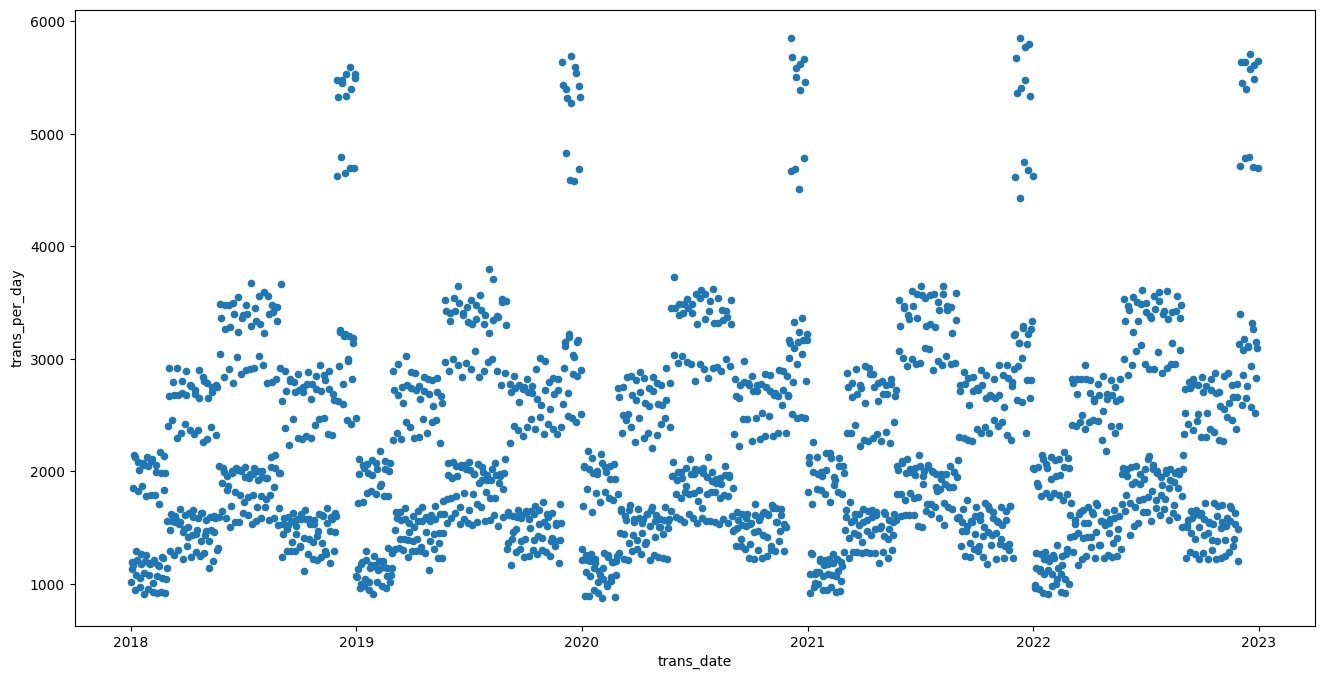

In [47]:
df.plot.scatter(x='trans_date', y='trans_per_day', figsize=(16,8))

In [48]:
df.set_index('trans_date', inplace=True)
df.head()

,trans_per_day,day
trans_date,,
2018-01-01,1016,1
2018-01-02,1193,2
2018-01-03,1131,3
2018-01-04,1170,4
2018-01-05,1851,5


## Split Data

In [49]:
df.head()

,trans_per_day,day
trans_date,,
2018-01-01,1016,1
2018-01-02,1193,2
2018-01-03,1131,3
2018-01-04,1170,4
2018-01-05,1851,5


In [50]:
len(df)

1826

In [51]:
train = df.iloc[:1826-30]
test = df.iloc[1826-30:]


In [52]:
len(test)

30

## Scale Data

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# FIT ONLY TRAIN DATA, OTHERWISE LEAKS SOME OF THE TEST DATA
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate time series data to cover test data

In [54]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [55]:
len(df)-7-7  # Subtract test data and then subtract elements to build first array

1812

In [56]:
df.head()

,trans_per_day,day
trans_date,,
2018-01-01,1016,1
2018-01-02,1193,2
2018-01-03,1131,3
2018-01-04,1170,4
2018-01-05,1851,5


In [57]:
len(generator)

895

In [58]:
generator[0]

(array([[[0.02771641, 0.        ],
         [0.06326572, 0.03333333],
         [0.05081342, 0.06666667],
         [0.05864631, 0.1       ],
         [0.19542077, 0.13333333],
         [0.25527214, 0.16666667],
         [0.25165696, 0.2       ]],
 
        [[0.06326572, 0.03333333],
         [0.05081342, 0.06666667],
         [0.05864631, 0.1       ],
         [0.19542077, 0.13333333],
         [0.25527214, 0.16666667],
         [0.25165696, 0.2       ],
         [0.01285399, 0.23333333]]]),
 array([[0.01285399, 0.23333333],
        [0.03996787, 0.26666667]]))

In [59]:
generator[0][0].shape

(2, 7, 2)

In [60]:
generator[0][1].shape

(2, 2)

In [62]:
n_features=len(df.columns)

# Create the Model

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               41200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 41301 (161.33 KB)
Trainable params: 41301 (161.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
model.fit(generator,epochs=30)


Epoch 1/30


2024-04-08 00:12:06.611368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


895/895 [==============================] - 96s 102ms/step - loss: 0.0598
Epoch 2/30
895/895 [==============================] - 90s 101ms/step - loss: 0.0531
Epoch 3/30
895/895 [==============================] - 91s 102ms/step - loss: 0.0515
Epoch 4/30
895/895 [==============================] - 90s 101ms/step - loss: 0.0505
Epoch 5/30
895/895 [==============================] - 90s 101ms/step - loss: 0.0503
Epoch 6/30
895/895 [==============================] - 89s 99ms/step - loss: 0.0498
Epoch 7/30
895/895 [==============================] - 90s 101ms/step - loss: 0.0494
Epoch 8/30
895/895 [==============================] - 90s 101ms/step - loss: 0.0496
Epoch 9/30
895/895 [==============================] - 82s 91ms/step - loss: 0.0492
Epoch 10/30
895/895 [==============================] - 57s 64ms/step - loss: 0.0493
Epoch 11/30
895/895 [==============================] - 57s 63ms/step - loss: 0.0490
Epoch 12/30
895/895 [==============================] - 57s 64ms/step - loss: 0.0484
Epoch

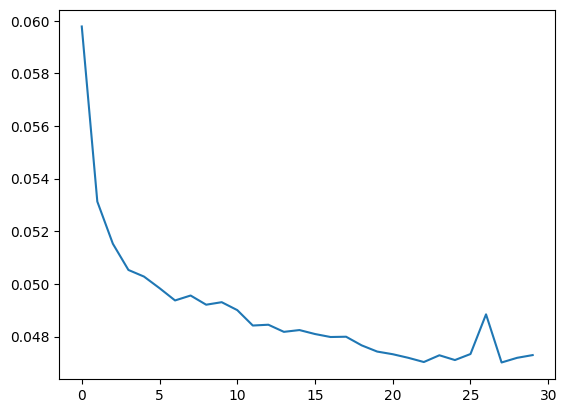

In [65]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaulate the test data

In [66]:
first_eval_batch = scaled_train[-7:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))



1/1 [==============================] - 0s 175ms/step


2024-04-08 00:45:30.017816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [67]:
current_batch.shape

(1, 7, 2)

In [3]:
np.append(current_batch[:,1:,:],[[[2,7]]],axis=1)

NameError: name 'current_batch' is not defined

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# go beyond len(test) to go into the unknown future (no way to measure success except wait!)
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse predictions and compare

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

In [ ]:
test.head()

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['trans_per_day'], test['Predictions']))
mse=mean_squared_error(test['trans_per_day'], test['Predictions'])
print(rmse)
print(mse)